In [1]:
import pandas as pd
import numpy as np

import requests
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18,9

def parser(time_data):
    return pd.datetime.strptime('2017-'+time_data,'%Y-%d-%m %H:%M:%S')
data = pd.read_csv('../data/namenode_1130-1212.csv',header=0,index_col=0, parse_dates=[0], date_parser=parser)

data = data.rename(columns={'cpu process':'top_cpu','memory process':'top_mem'})
data['top_cpu'] = data['top_cpu'].str.partition('/')[0]
data['top_mem'] = data['top_mem'].str.partition('/')[0]

/home/zhiyedan/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


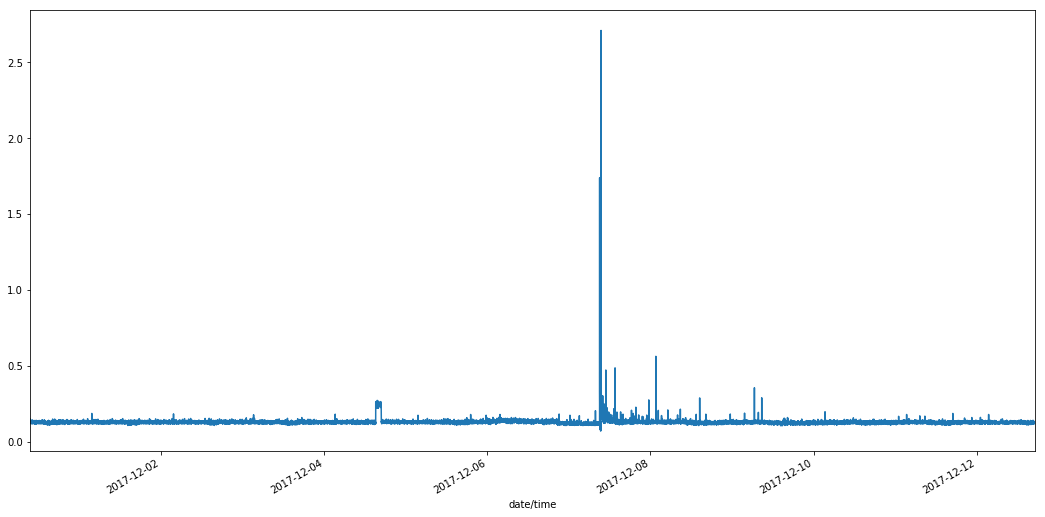

In [2]:
data['usr'].plot()
plt.show()

Text(0.5,1,u'usr')

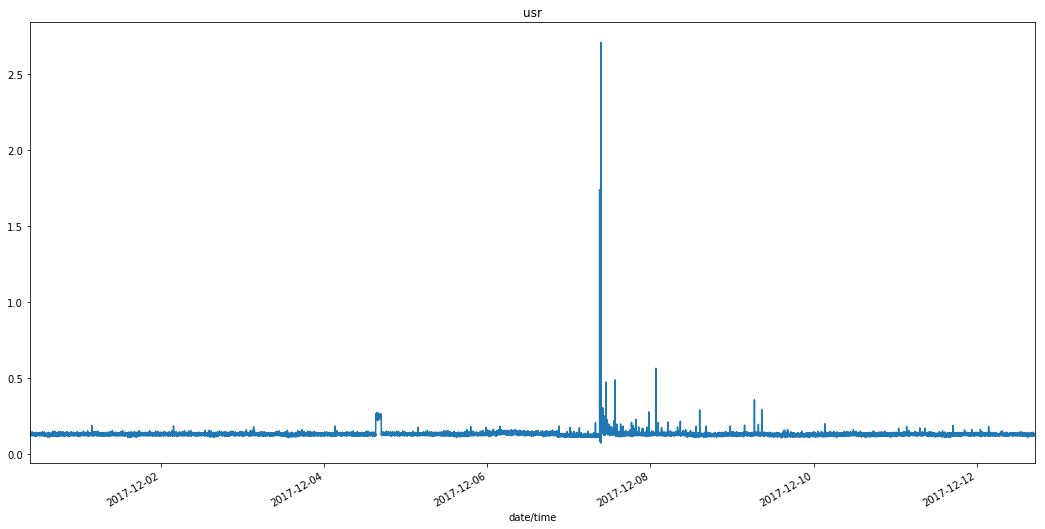

Text(0.5,1,u'sys')

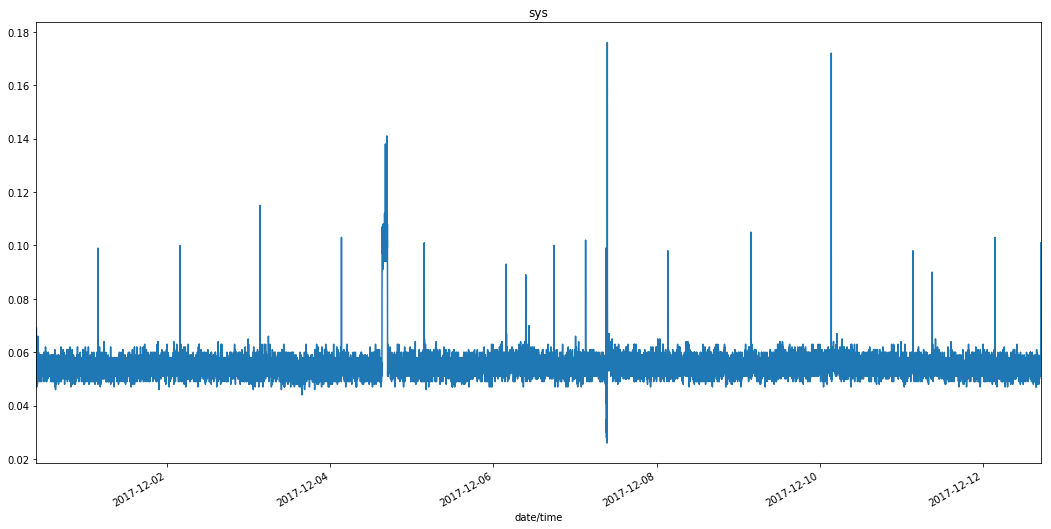

Text(0.5,1,u'used')

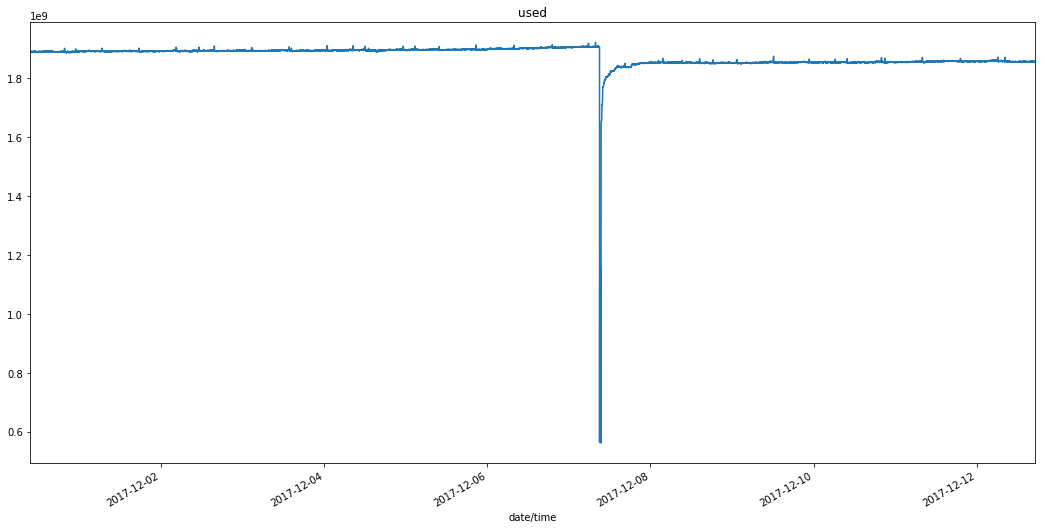

Text(0.5,1,u'buff')

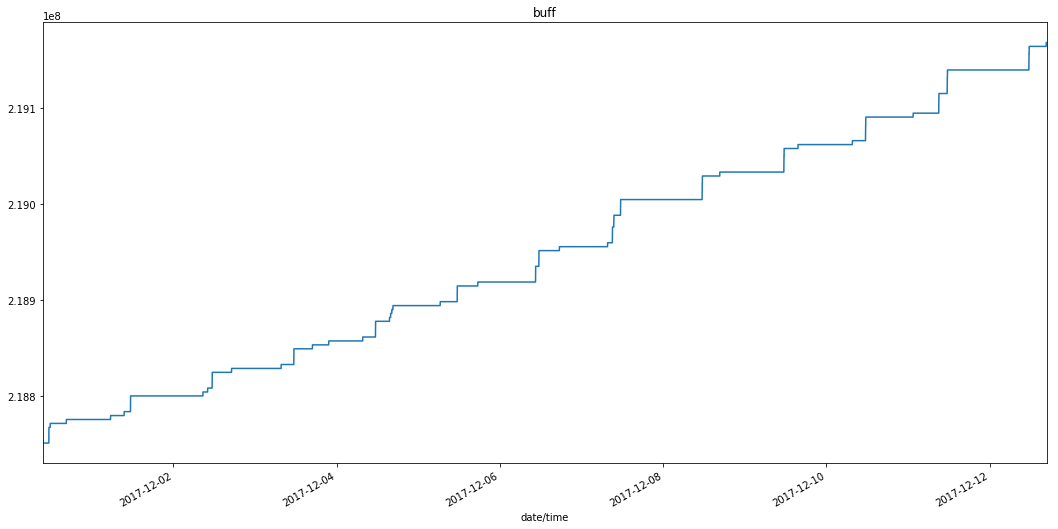

Text(0.5,1,u'cach')

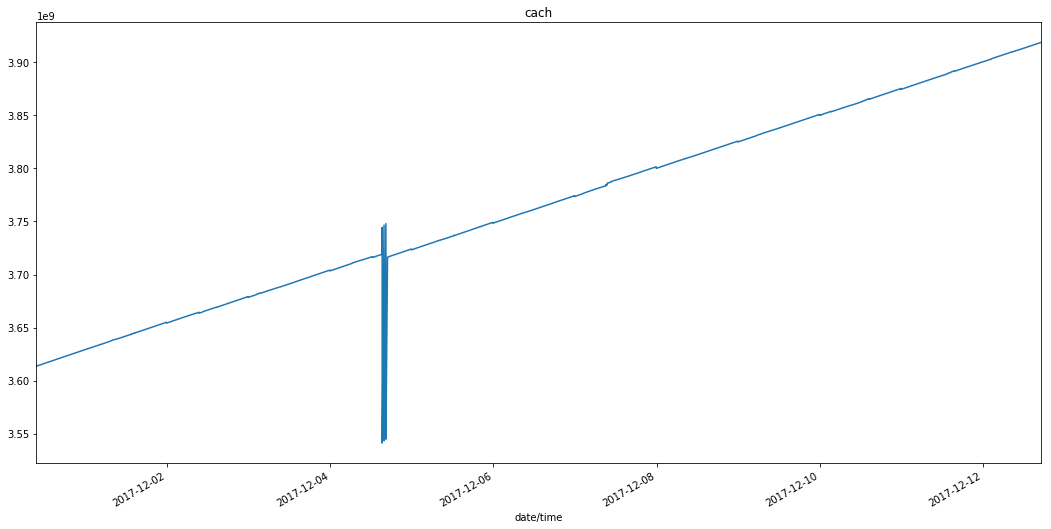

Text(0.5,1,u'free')

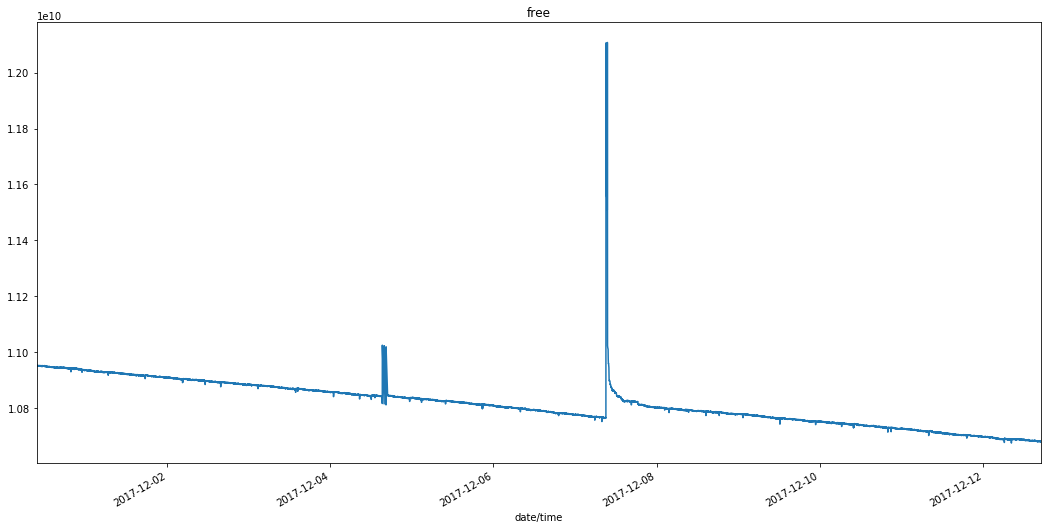

Text(0.5,1,u'recv')

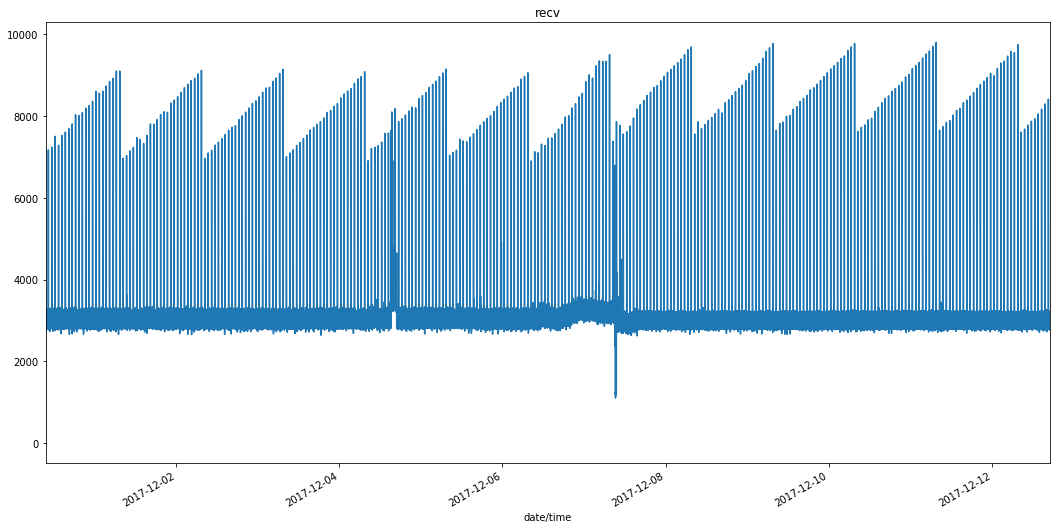

Text(0.5,1,u'send')

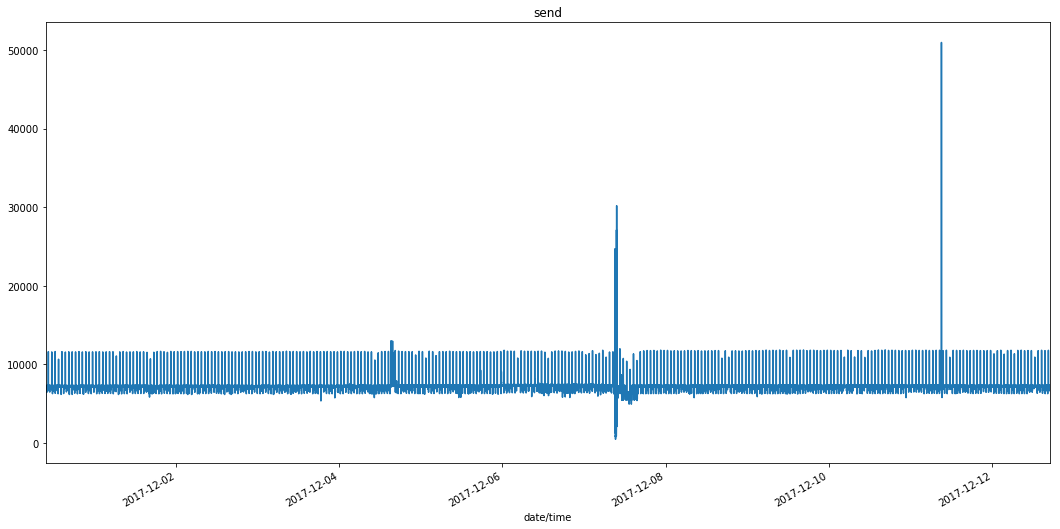

Text(0.5,1,u'read')

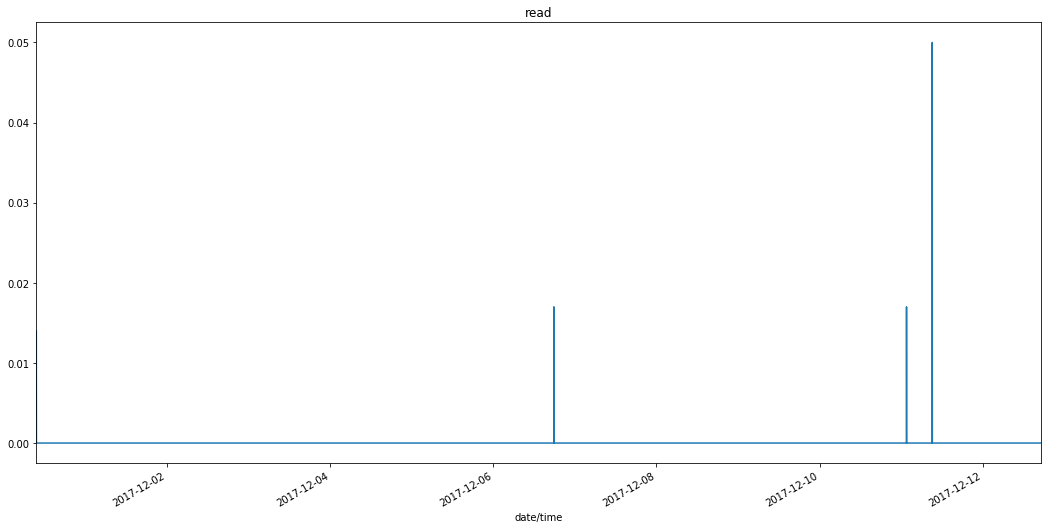

Text(0.5,1,u'writ')

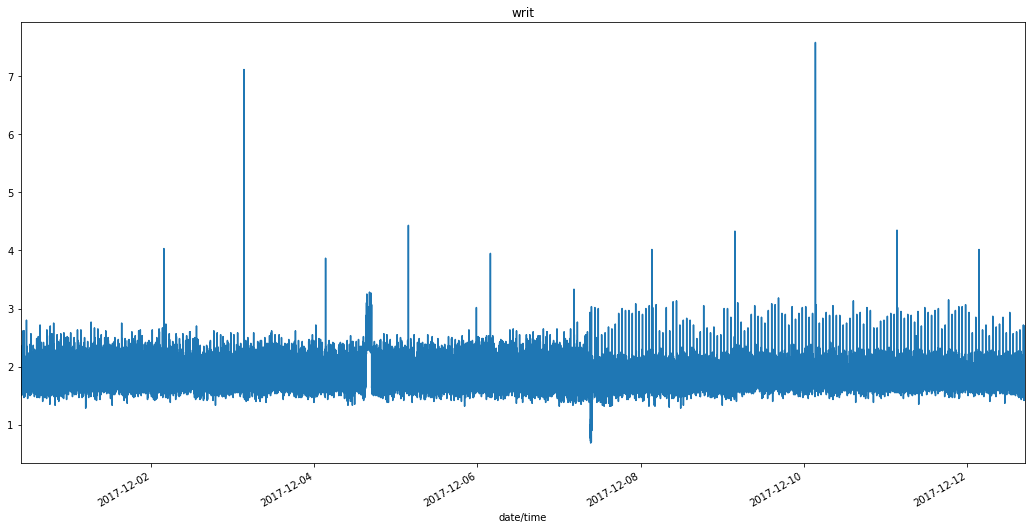

In [26]:
cols = ['usr', 'sys', 'used', 'buff', 'cach','free', 'recv', 'send', 'read', 'writ']
for col in cols:
    data[col].plot()
    plt.title(col)
    plt.show()

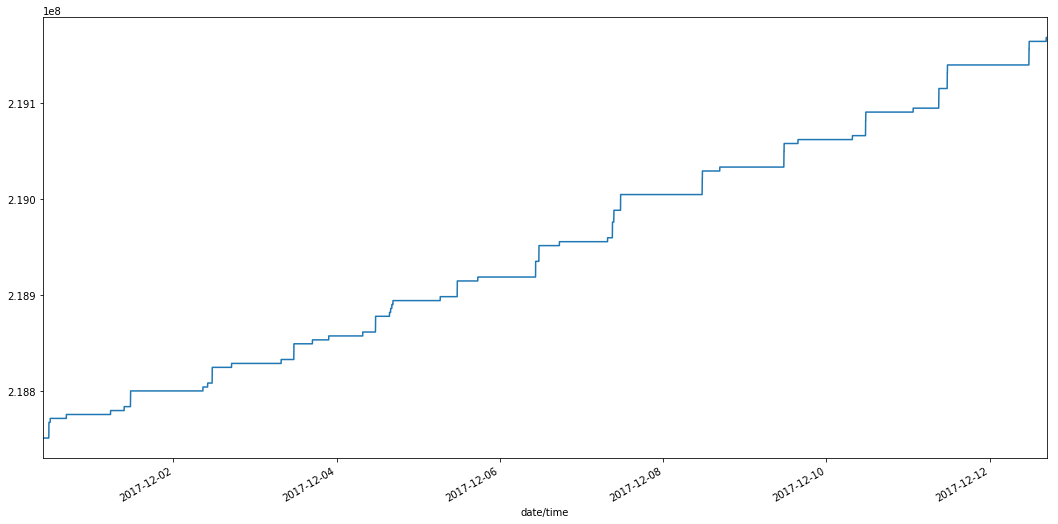

In [3]:
buff_data = data['buff'][::]
buff_data.plot()
plt.show()

In [4]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler()
buff_norm = scaler.fit_transform(buff_data.values.reshape(-1,1))
norm_data = pd.Series(buff_norm.T[0],index=buff_data.index)

## 检查平稳性

In [11]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24*60,center=False).mean() 
    rolstd = timeseries.rolling(window=24*60,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolmean.index.to_pydatetime(), rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.index.to_pydatetime(), rolstd.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

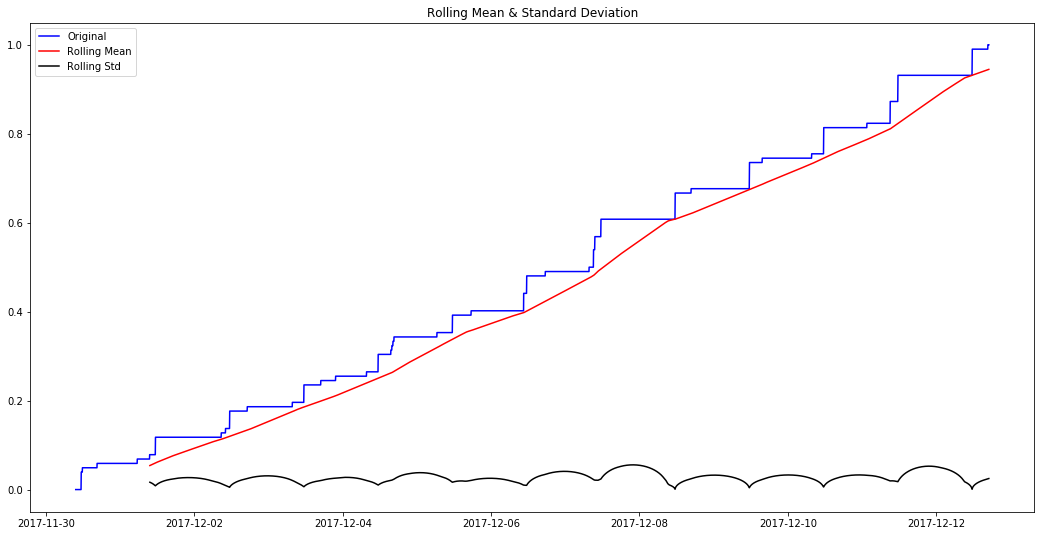

Results of Dickey-Fuller Test:
Test Statistic                     0.075436
p-value                            0.964343
#Lags Used                        27.000000
Number of Observations Used    17696.000000
Critical Value (5%)               -2.861703
Critical Value (1%)               -3.430720
Critical Value (10%)              -2.566857
dtype: float64


In [14]:
test_stationarity(norm_data)

# 做一次diff

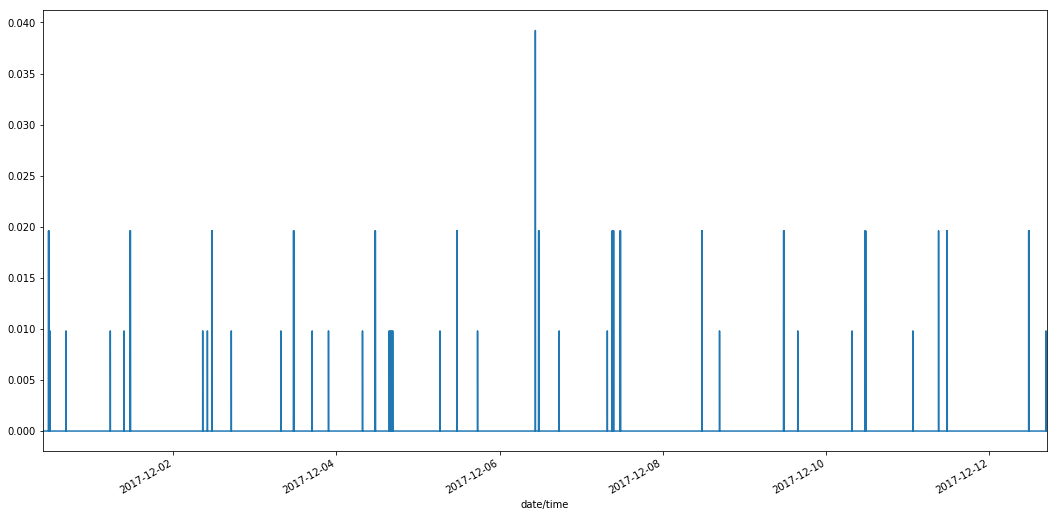

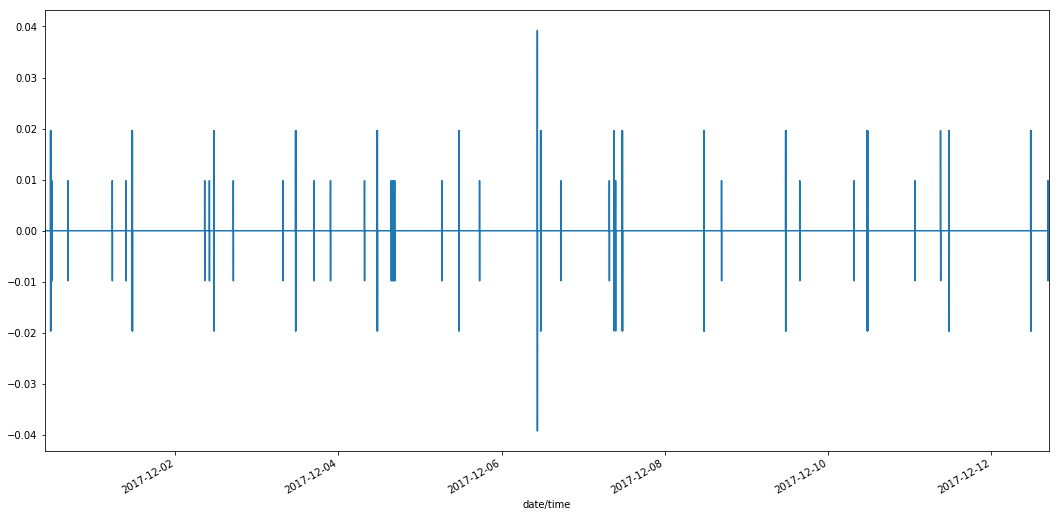

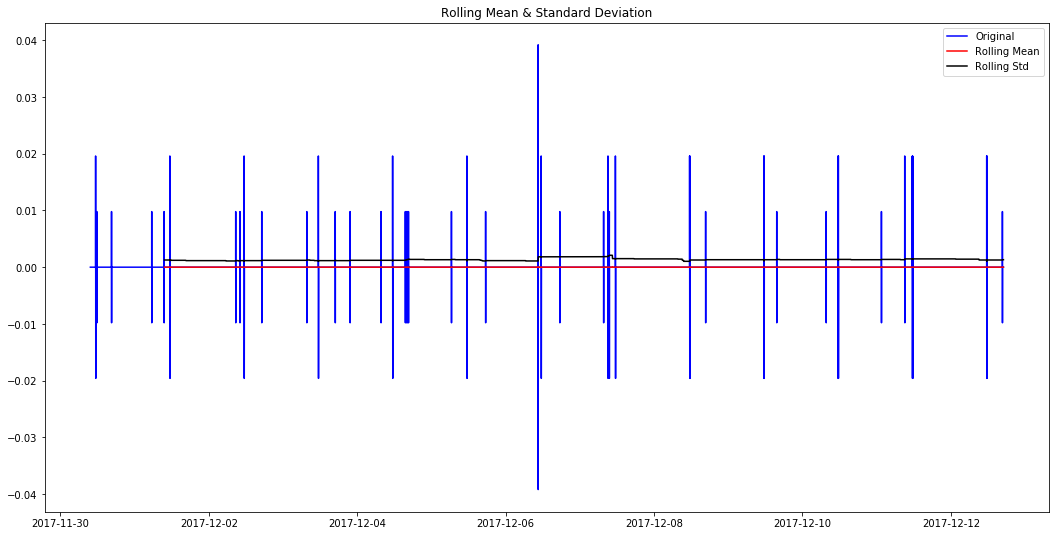

Results of Dickey-Fuller Test:


LinAlgError: SVD did not converge

In [100]:
# decomposition = seasonal_decompose(norm_data)
# trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid
norm_data_diff = norm_data - norm_data.shift()
norm_data_diff.plot()
plt.show()
diff2 = norm_data_diff - norm_data_diff.shift()
diff2.plot()
plt.show()
norm_data_diff.dropna(inplace=True)
test_stationarity(diff2)

In [75]:
len(norm_data)
len(norm_data_diff)

17724

17723

# Find optimal parameters and build an ARIMA model

Text(0.5,1,u'Autocorrelation Function')

Text(0.5,1,u'Partial Autocorrelation Function')

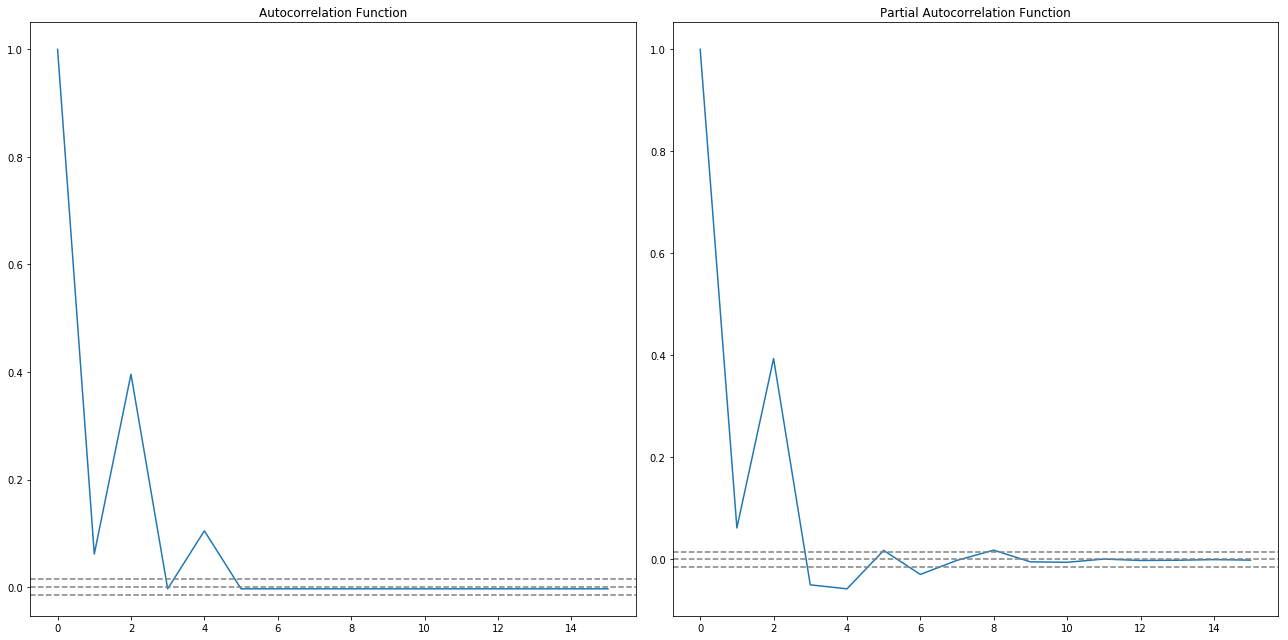

In [85]:
#ACF and PACF plots

lag_acf = acf(norm_data_diff, nlags=15)
lag_pacf = pacf(norm_data_diff, nlags=15, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(norm_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(norm_data_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(norm_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(norm_data_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [94]:
model = ARIMA(norm_data,order=(7,2,5))
results_ARIMA = model.fit(disp=-1)

Text(0.5,1,u'RSS: nan')

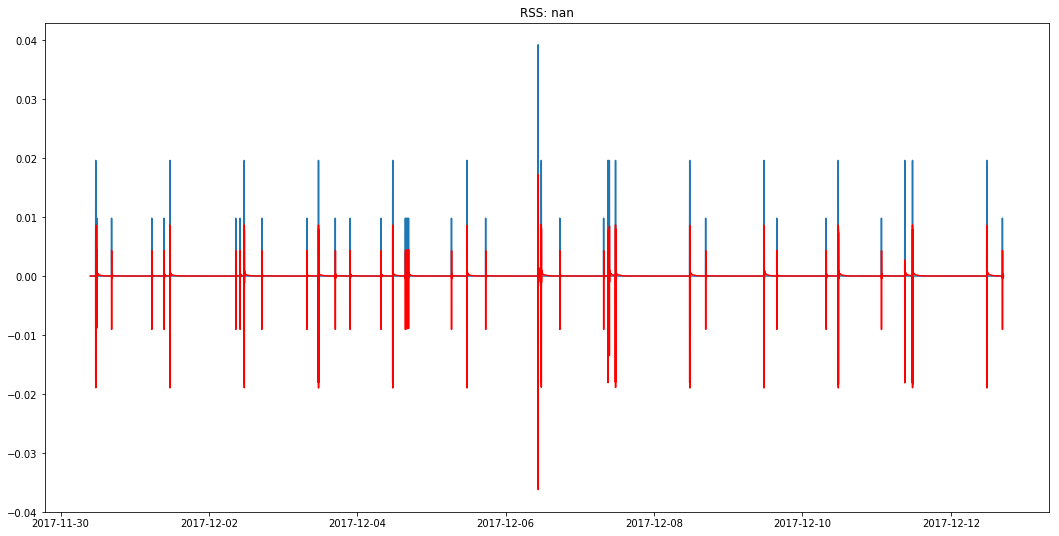

In [96]:
plt.plot(norm_data_diff.index.to_pydatetime(), norm_data_diff.values)
plt.plot(norm_data_diff[1:].index.to_pydatetime(), results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - norm_data_diff)**2))

In [37]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                17722
Model:                 ARIMA(5, 1, 5)   Log Likelihood               98738.212
Method:                       css-mle   S.D. of innovations              0.001
Date:                Wed, 13 Dec 2017   AIC                        -197452.425
Time:                        10:33:46   BIC                        -197359.034
Sample:                    11-30-2017   HQIC                       -197421.690
                         - 12-12-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.278e-09   1.65e-07     -0.014      0.989   -3.27e-07    3.22e-07
ar.L1.D.y     -0.1511      0.103     -1.471      0.141      -0.352       0.050
ar.L2.D.y     -0.3749      0.144     -2.604      0.0

                  0
count  1.772200e+04
mean   2.601974e-07
std    9.206149e-04
min   -1.724239e-02
25%   -2.565722e-05
50%   -1.816256e-06
75%    8.097334e-08
max    3.921578e-02


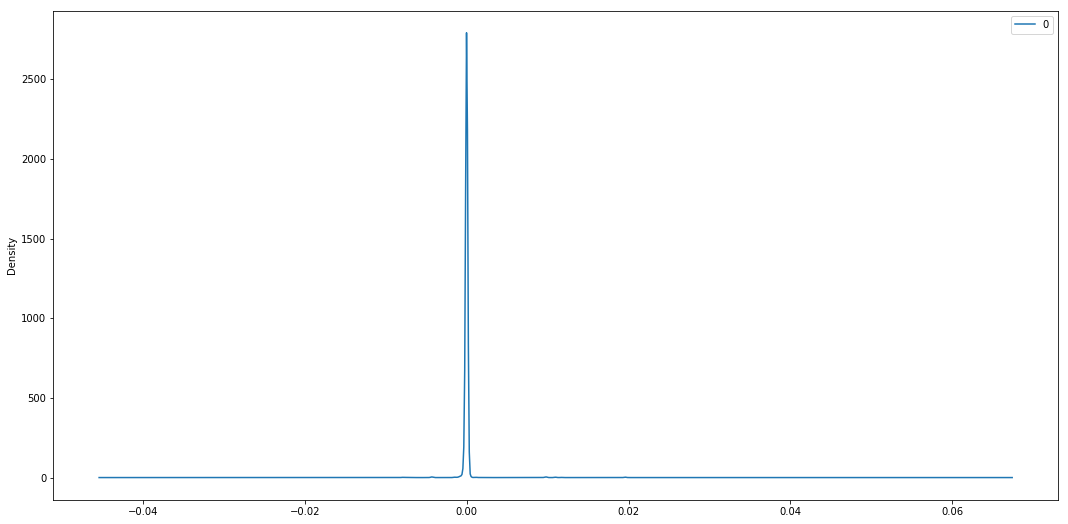

In [38]:
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [97]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_norm = pd.Series(norm_data.iloc[0],index=norm_data.index)
predictions_ARIMA_norm = predictions_ARIMA_norm.add(predictions_ARIMA_diff_cumsum,fill_value=0)

Text(0.5,1,u'RMSE: 0.5559')

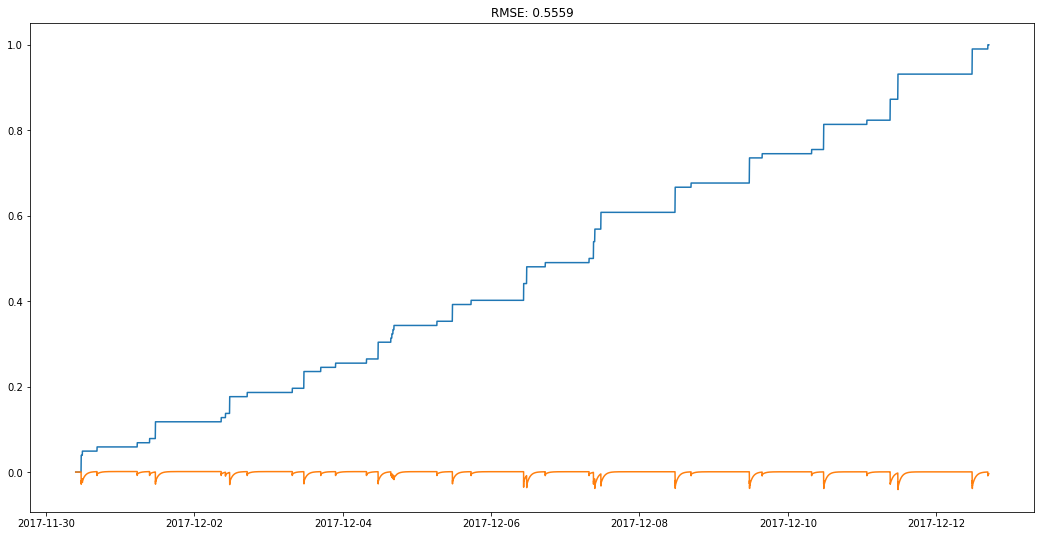

In [98]:
plt.plot(norm_data.index.to_pydatetime(), norm_data.values)
plt.plot(norm_data.index.to_pydatetime(), predictions_ARIMA_norm.values)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_norm-norm_data)**2)/len(norm_data)))

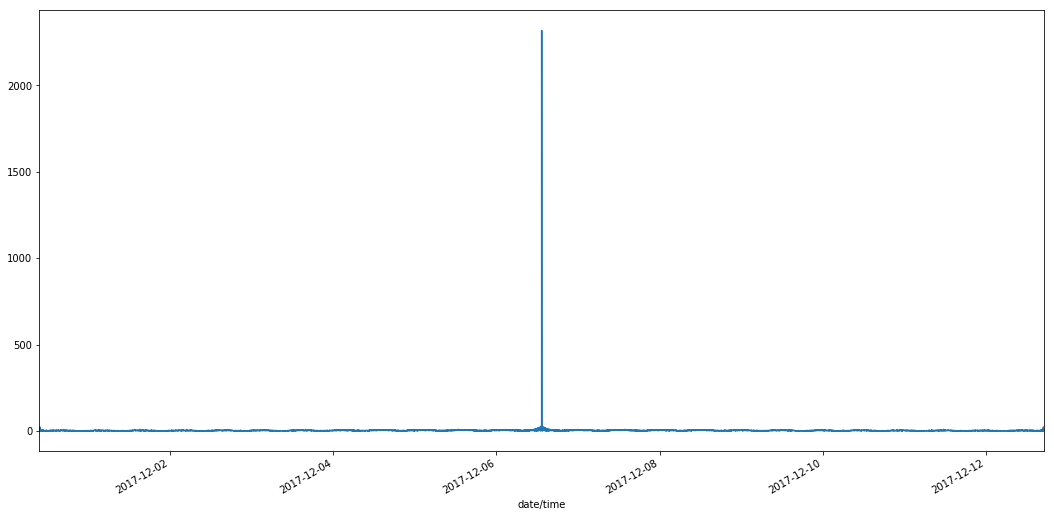

In [110]:
tmp = data.copy()
tmp['fft'] = np.fft.fft(data['usr'])
tmp['xf_abs'] = np.fft.fftshift(abs(tmp['fft'].values)) 
tmp['xf_abs'].plot()
plt.show()


NameError: name 'data' is not defined